Importing Libraries

In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
classes = ["./Apple_black_rot", "./Apple_cedar_rust", "./Apple_scab"] 
image_size = (128, 128)

 Load & Preprocess Images

In [3]:
X, y = [], []

for i, category in enumerate(classes):
    folder_path = category
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize
            img = img / 255.0  # Normalize
            X.append(img)
            y.append(i)  # Label (0=Rot, 1=Rust, 2=Scab)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# One-hot encode labels
y = to_categorical(y, num_classes=len(classes))

print(f"Dataset Loaded: {X.shape}, Labels: {y.shape}")

Dataset Loaded: (480, 128, 128, 3), Labels: (480, 3)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")


Training Set: (384, 128, 128, 3), Test Set: (96, 128, 128, 3)


Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

datagen.fit(X_train)


Building the Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Convolutional layers with pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization to avoid overfitting
model.add(Dense(len(classes), activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the Model

In [7]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.3830 - loss: 1.0988 - val_accuracy: 0.6875 - val_loss: 0.8130
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.6577 - loss: 0.7773 - val_accuracy: 0.8646 - val_loss: 0.3742
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.8507 - loss: 0.4058 - val_accuracy: 0.7083 - val_loss: 0.7303
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 416ms/step - accuracy: 0.8667 - loss: 0.3646 - val_accuracy: 0.9167 - val_loss: 0.2827
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step - accuracy: 0.8558 - loss: 0.3499 - val_accuracy: 0.9167 - val_loss: 0.2976
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.9227 - loss: 0.2496 - val_accuracy: 0.8646 - val_loss: 0.4017
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.9068 - loss: 0.2979 - val_accuracy: 0.8646 - val_loss: 0.3718
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 513ms/step - accuracy: 0.9315 - loss: 0.2452 - val_accuracy: 0

 Evaluating and Plotting Results

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7500 - loss: 0.9724
Test Accuracy: 0.75


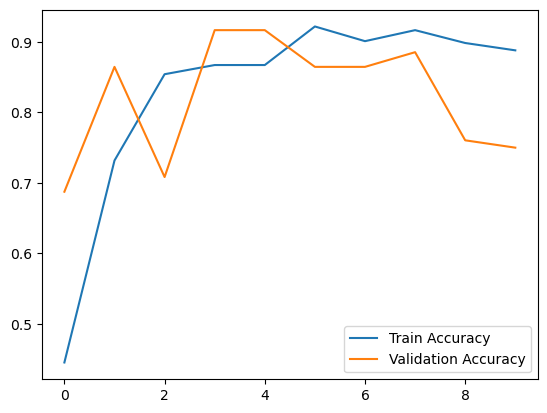

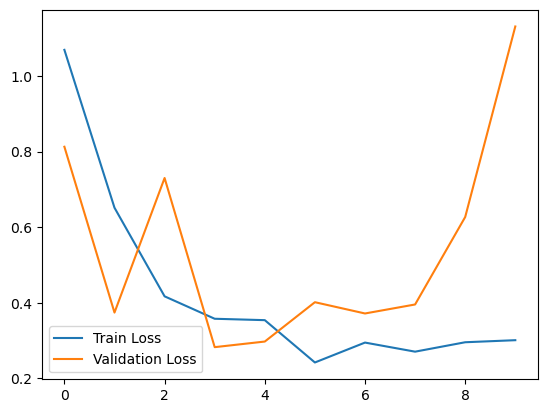

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Prepare the Image for Classification

In [10]:
def prepare_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)  
    img = img / 255.0  
    img = np.expand_dims(img, axis=0)
    return img

Predict with the Model

In [11]:
def classify_image(image_path):
    img = prepare_image(image_path)
    prediction = model.predict(img)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    
    # Map the predicted class to its label
    class_labels = ["Apple_black_rot", "Apple_cedar_rust", "Apple_scab"]
    predicted_label = class_labels[predicted_class]
    
    print(f"Predicted label: {predicted_label}")
    return predicted_label


Classify New Images 

In [12]:
import os

base_path = os.getcwd()  # Get current working directory
folders = ["Apple_black_rot", "Apple_cedar_rust", "Apple_scab"]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        print(f"Images in {folder}: {os.listdir(folder_path)[:5]}")  # Show first 5 images


Images in Apple_black_rot: ['Black_rot (1).JPG', 'Black_rot (10).JPG', 'Black_rot (100).JPG', 'Black_rot (101).JPG', 'Black_rot (102).JPG']
Images in Apple_cedar_rust: ['Cedar_rust (1).JPG', 'Cedar_rust (10).JPG', 'Cedar_rust (100).JPG', 'Cedar_rust (101).JPG', 'Cedar_rust (102).JPG']
Images in Apple_scab: ['Scab (1).JPG', 'Scab (10).JPG', 'Scab (100).JPG', 'Scab (101).JPG', 'Scab (102).JPG']


In [13]:
image_path = os.path.join(base_path, "Apple_black_rot", "Black_rot (1).jpg")  # Replace with actual filename
print("File exists:", os.path.exists(image_path))


File exists: True


In [14]:
classify_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Predicted label: Apple_black_rot


'Apple_black_rot'

In [15]:
image_path = os.path.join(base_path, "Apple_black_rot", "Black_rot (3).jpg")  # Replace with actual filename
print("File exists:", os.path.exists(image_path))


File exists: True


In [16]:
classify_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted label: Apple_black_rot


'Apple_black_rot'

Classify a Random Image

In [17]:
import random

category = random.choice(folders)  # Choose a random folder
folder_path = os.path.join(base_path, category)
image_name = random.choice(os.listdir(folder_path))  # Pick a random image
image_path = os.path.join(folder_path, image_name)

print(f"Testing with: {image_path}")
classify_image(image_path)


Testing with: C:\Users\KIIT\Desktop\apple_disease_project\Apple_cedar_rust\Cedar_rust (98).JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label: Apple_cedar_rust


'Apple_cedar_rust'

In [18]:
image_path = os.path.join(base_path, "Apple_cedar_rust", "Cedar_rust (9).jpg")  # Replace with actual filename
print("File exists:", os.path.exists(image_path))


File exists: True


In [19]:
classify_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted label: Apple_cedar_rust


'Apple_cedar_rust'

Display the Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted label: Apple_cedar_rust


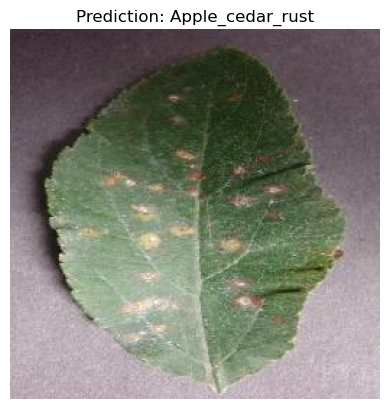

In [20]:
def show_image_with_prediction(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying
    plt.imshow(img)
    plt.title(f"Prediction: {classify_image(image_path)}")
    plt.axis('off')
    plt.show()

# Call this function to display the image with its predicted label
show_image_with_prediction(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted label: Apple_cedar_rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted label: Apple_black_rot


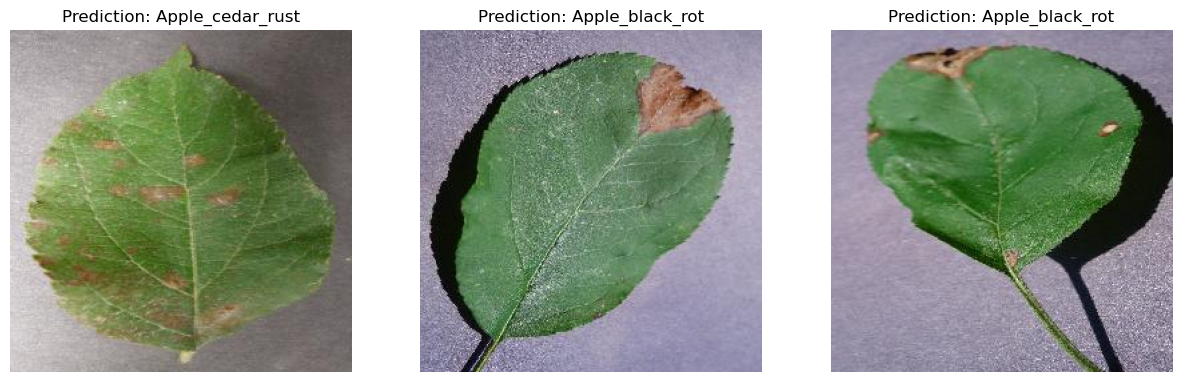

In [21]:
import random

def show_multiple_images(num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create a grid for images

    base_path = os.getcwd()
    folders = ["Apple_black_rot", "Apple_cedar_rust", "Apple_scab"]
    
    for i in range(num_images):
        category = random.choice(folders)  # Pick a random folder
        folder_path = os.path.join(base_path, category)
        image_name = random.choice(os.listdir(folder_path))  # Pick a random image
        image_path = os.path.join(folder_path, image_name)
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        prediction = classify_image(image_path)  # Get prediction
        
        axes[i].imshow(img)
        axes[i].set_title(f"Prediction: {prediction}")
        axes[i].axis('off')

    plt.show()

# Call function to show multiple images
show_multiple_images(num_images=3)  # Change num_images as needed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted label: Apple_black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted label: Apple_black_rot


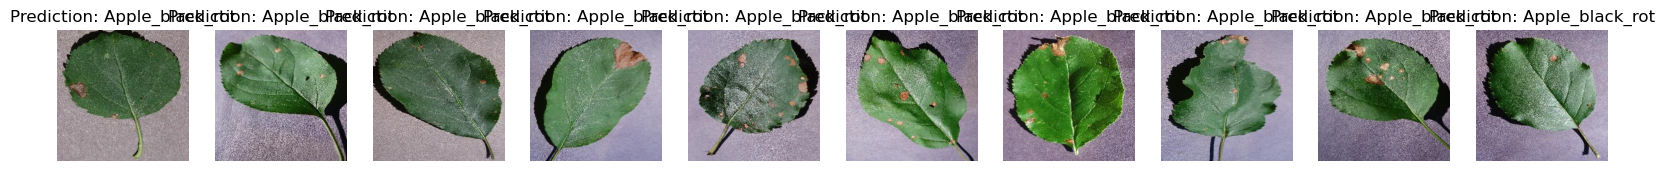

In [22]:
def show_all_images_in_folder(folder_name):
    folder_path = os.path.join(os.getcwd(), folder_name)
    image_files = os.listdir(folder_path)[:10]  # Limit to 10 images

    fig, axes = plt.subplots(1, len(image_files), figsize=(20, 5))

    for i, image_name in enumerate(image_files):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        prediction = classify_image(image_path)

        axes[i].imshow(img)
        axes[i].set_title(f"Prediction: {prediction}")
        axes[i].axis('off')

    plt.show()

# Example usage
show_all_images_in_folder("Apple_black_rot")  # Change folder name as needed


Evaluate Model Performance

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
                  precision    recall  f1-score   support

 Apple_black_rot       0.62      1.00      0.76        34
Apple_cedar_rust       0.90      0.90      0.90        31
      Apple_scab       1.00      0.32      0.49        31

        accuracy                           0.75        96
       macro avg       0.84      0.74      0.72        96
    weighted avg       0.83      0.75      0.72        96



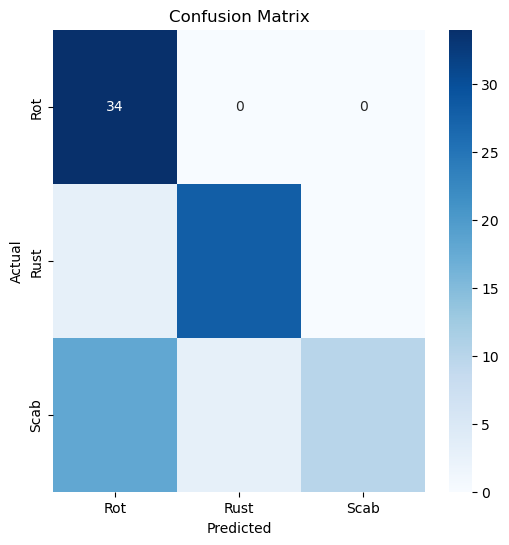

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # True labels

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=["Apple_black_rot", "Apple_cedar_rust", "Apple_scab"]))

# Plot confusion matrix
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Rot", "Rust", "Scab"], yticklabels=["Rot", "Rust", "Scab"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.8523 - loss: 0.4301 - val_accuracy: 0.7708 - val_loss: 0.4529
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.8810 - loss: 0.2848 - val_accuracy: 0.9479 - val_loss: 0.1220
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.9795 - loss: 0.1008 - val_accuracy: 0.9688 - val_loss: 0.0940
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.9816 - loss: 0.0653 - val_accuracy: 0.9688 - val_loss: 0.1344
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.9710 - loss: 0.0680 - val_accuracy: 0.9583 - val_loss: 0.1316
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.9892 - loss: 0.0312 - val_accuracy: 0.9688 - val_loss: 0.1250
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.9932 - loss: 0.0355 - val_accuracy: 0.9688 - val_loss: 0.1253
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.9894 - loss: 0.0394 - val_accuracy: 0.

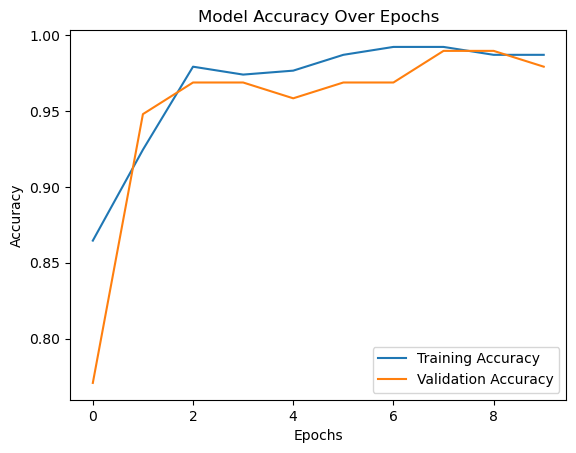

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()


In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9857 - loss: 0.1115
Test Accuracy: 97.92%


In [27]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # True labels

print(classification_report(y_true_classes, y_pred_classes, target_names=["Apple_black_rot", "Apple_cedar_rust", "Apple_scab"]))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
                  precision    recall  f1-score   support

 Apple_black_rot       0.97      1.00      0.99        34
Apple_cedar_rust       1.00      0.97      0.98        31
      Apple_scab       0.97      0.97      0.97        31

        accuracy                           0.98        96
       macro avg       0.98      0.98      0.98        96
    weighted avg       0.98      0.98      0.98        96



In [30]:
model.save("apple_disease_model.keras")  